# Imports

#### Some imports are here as a legacy from the scarpe notebook.

In [1]:
import csv
import errno
import itertools
import os
import time

from bs4 import BeautifulSoup
import click
import dataset
import funcy as fy
import requests

from pyquery import PyQuery
import time
import traceback

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
%matplotlib inline

from datetime import datetime
import time

## Load file with 2016 results

In [2]:
df = pd.read_csv('marathon_results_2016.csv')

In [3]:
df.describe()

,Age,Overall,Gender,Division
count,26630.000000,26630.000000,26630.000000,26630.000000
mean,42.514044,13314.764176,6707.085242,1613.305896
std,11.347955,7687.226481,3928.246611,1443.420260
min,18.000000,1.000000,1.000000,1.000000
25%,34.000000,6658.250000,3329.000000,510.000000
50%,43.000000,13314.500000,6657.500000,1180.000000
75%,51.000000,19971.750000,9986.000000,2198.000000
max,83.000000,26629.000000,14463.000000,5946.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26630 entries, 0 to 26629
Data columns (total 24 columns):
Bib              26630 non-null object
Name             26630 non-null object
Age              26630 non-null int64
M/F              26630 non-null object
City             26629 non-null object
State            23783 non-null object
Country          26630 non-null object
Citizen          1122 non-null object
Unnamed: 8       83 non-null object
5K               26630 non-null object
10K              26630 non-null object
15K              26630 non-null object
20K              26630 non-null object
Half             26630 non-null object
25K              26630 non-null object
30K              26630 non-null object
35K              26630 non-null object
40K              26630 non-null object
Pace             26630 non-null object
Proj Time        26630 non-null object
Official Time    26630 non-null object
Overall          26630 non-null int64
Gender           26630 non-null int64
D

#### change times from text to datetime

In [5]:
df['5K'] = pd.to_datetime(df['5K'], format='%H:%M:%S', errors='coerce')
df['10K'] = pd.to_datetime(df['10K'], format='%H:%M:%S', errors='coerce')
df['15K'] = pd.to_datetime(df['15K'], format='%H:%M:%S', errors='coerce')
df['20K'] = pd.to_datetime(df['20K'], format='%H:%M:%S', errors='coerce')
df['Half'] = pd.to_datetime(df['Half'], format='%H:%M:%S', errors='coerce')
df['25K'] = pd.to_datetime(df['25K'], format='%H:%M:%S', errors='coerce')
df['30K'] = pd.to_datetime(df['30K'], format='%H:%M:%S', errors='coerce')
df['35K'] = pd.to_datetime(df['35K'], format='%H:%M:%S', errors='coerce')
df['40K'] = pd.to_datetime(df['40K'], format='%H:%M:%S', errors='coerce')
df['Pace'] = pd.to_datetime(df['Pace'], format='%H:%M:%S', errors='coerce')
df['Proj Time'] = pd.to_datetime(df['Proj Time'], format='%H:%M:%S', errors='coerce')
df['Official Time'] = pd.to_datetime(df['Official Time'], format='%H:%M:%S', errors='coerce')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26630 entries, 0 to 26629
Data columns (total 24 columns):
Bib              26630 non-null object
Name             26630 non-null object
Age              26630 non-null int64
M/F              26630 non-null object
City             26629 non-null object
State            23783 non-null object
Country          26630 non-null object
Citizen          1122 non-null object
Unnamed: 8       83 non-null object
5K               26578 non-null datetime64[ns]
10K              26601 non-null datetime64[ns]
15K              26616 non-null datetime64[ns]
20K              26607 non-null datetime64[ns]
Half             26613 non-null datetime64[ns]
25K              26620 non-null datetime64[ns]
30K              26606 non-null datetime64[ns]
35K              26618 non-null datetime64[ns]
40K              26616 non-null datetime64[ns]
Pace             26630 non-null datetime64[ns]
Proj Time        26521 non-null datetime64[ns]
Official Time    26630 non-n

## Finishers by age

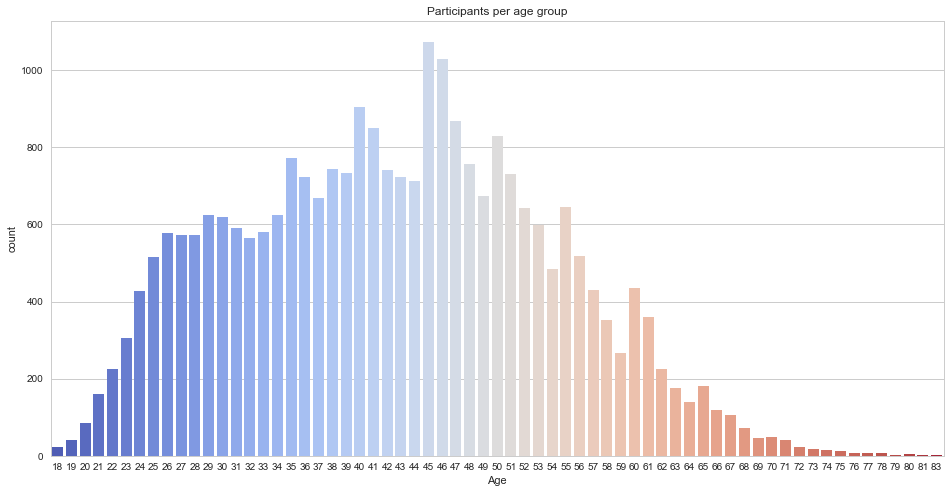

In [7]:
g = sns.countplot('Age', data=df, palette="coolwarm")
g.figure.set_size_inches(16,8)
g.set_title("Participants per age group")


### Finishers by age and gender

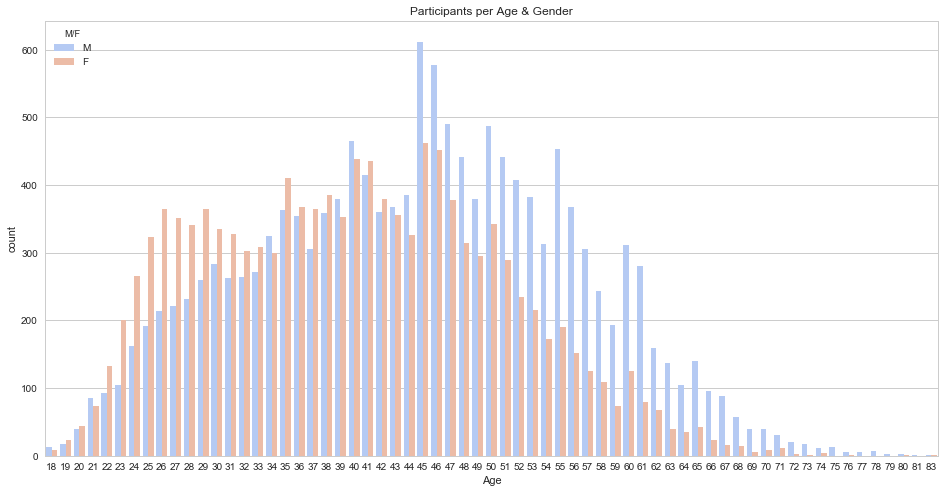

In [8]:
g = sns.countplot('Age', data=df, palette="coolwarm", hue='M/F')
g.figure.set_size_inches(16,8)
g.set_title("Participants per Age & Gender")

## Boxplot by age and gender

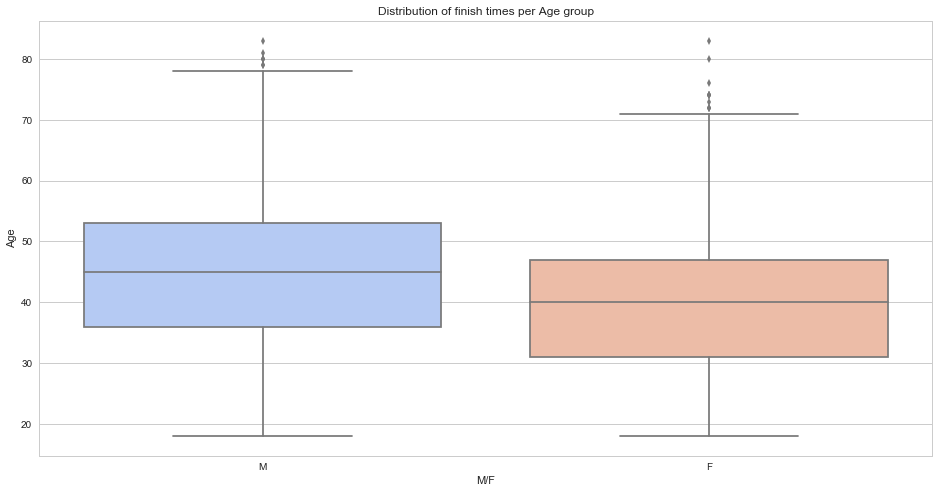

In [9]:
g = sns.boxplot(df['M/F'], df['Age'], palette="coolwarm")
g.figure.set_size_inches(16,8)
g.set_title("Distribution of finish times per Age group")

### Distribution of official times by age

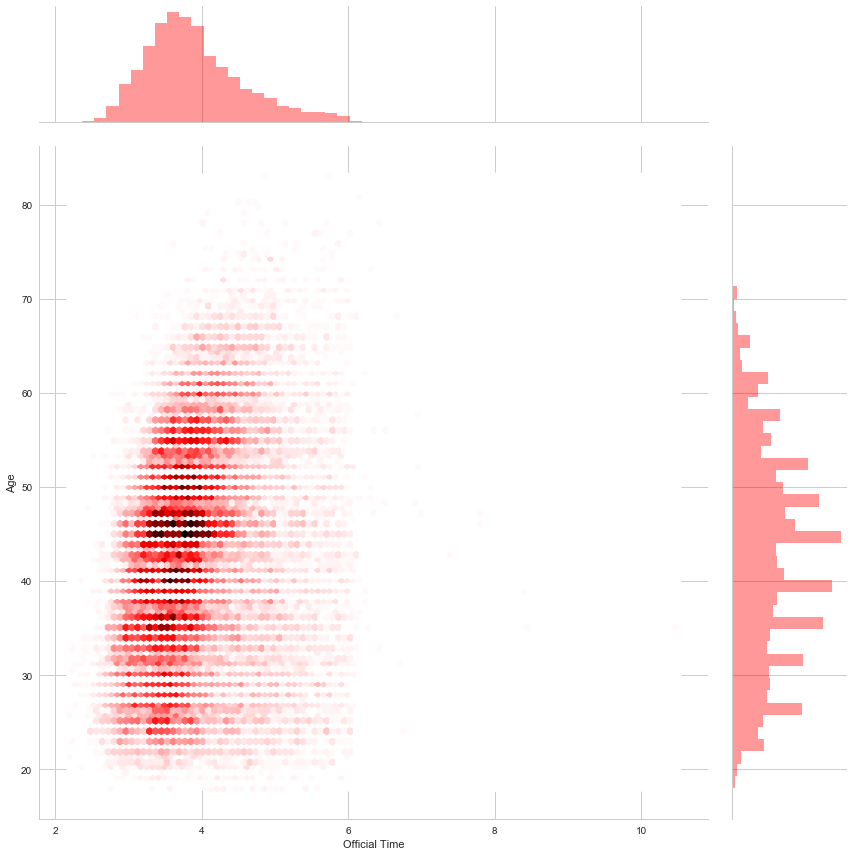

In [10]:
g = sns.jointplot((df['Official Time'].dt.minute/60 + df['Official Time'].dt.hour), df['Age'], stat_func=None, kind='hex', color="r", size=12)


### Boxplot of finishing times by age

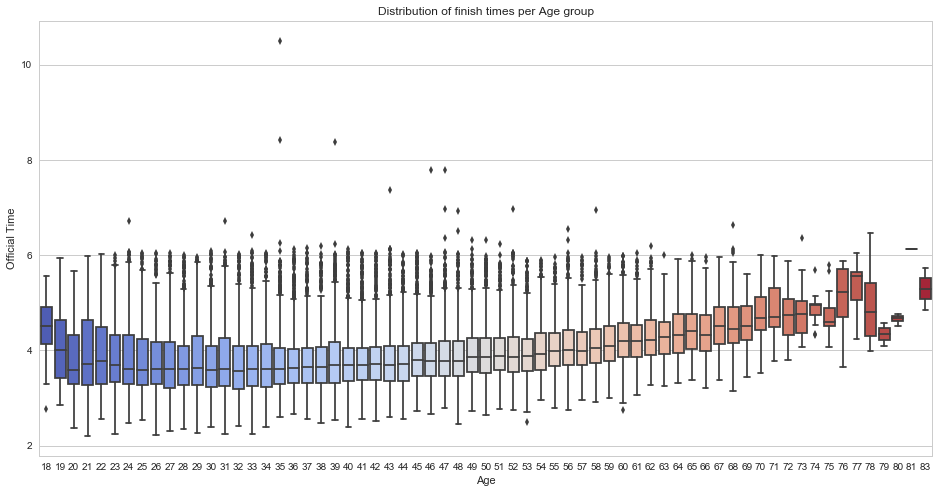

In [11]:
g = sns.boxplot(df['Age'], (df['Official Time'].dt.minute/60 + df['Official Time'].dt.hour), palette="coolwarm")
g.figure.set_size_inches(16,8)
g.set_title("Distribution of finish times per Age group")


### Overall placement by age and gender - probably useless...

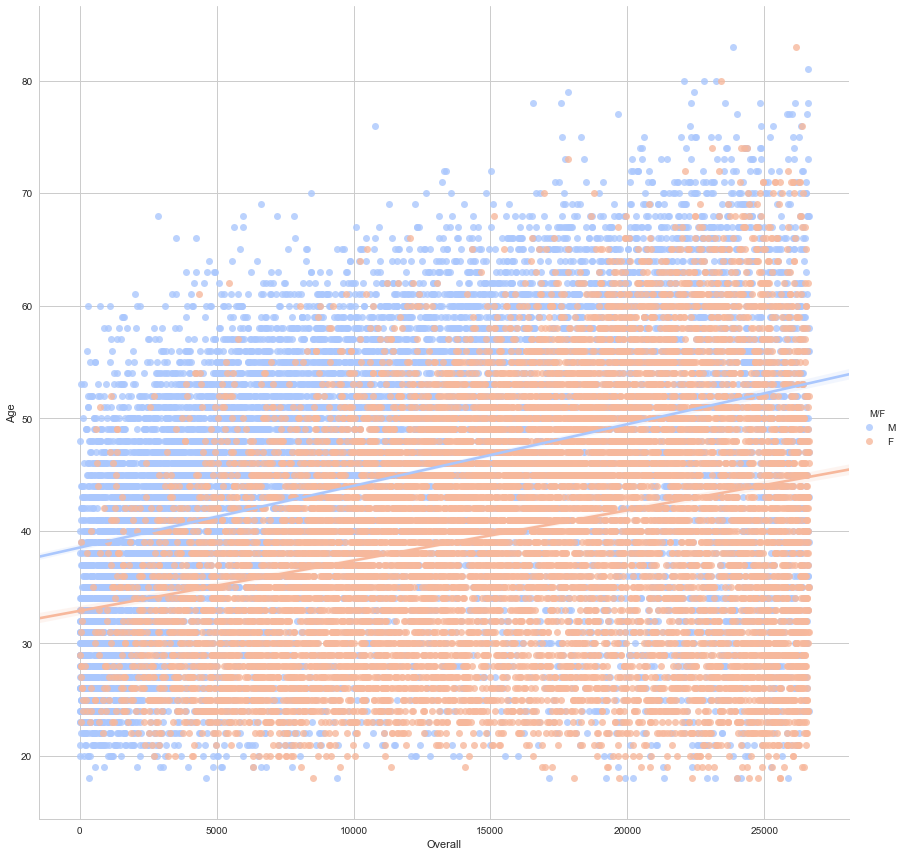

In [12]:
g = sns.lmplot(x='Overall', y='Age', data=df, hue='M/F', palette="coolwarm", size=12)


#### Separate the name column into first and last names

In [13]:
s = df['Name'].apply(lambda x: x.split(', '))
df['First Name'] = s.apply(lambda x: x[1])
df['Last Name'] = s.apply(lambda x: x[0])
df.drop('Name', axis=1, inplace=True)

## Most popular country - finishers

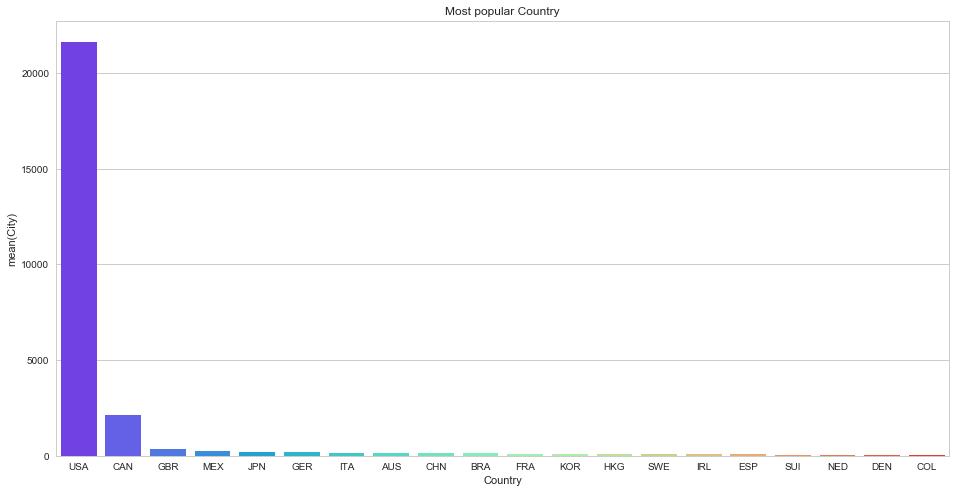

In [14]:
s = pd.DataFrame(df.groupby('Country').count()['City'].sort_values(ascending=False).head(20))
g = sns.barplot(s.index, s["City"], palette='rainbow')
g.figure.set_size_inches(16,8)
g.set_title("Most popular Country")

### Most popular country without USA

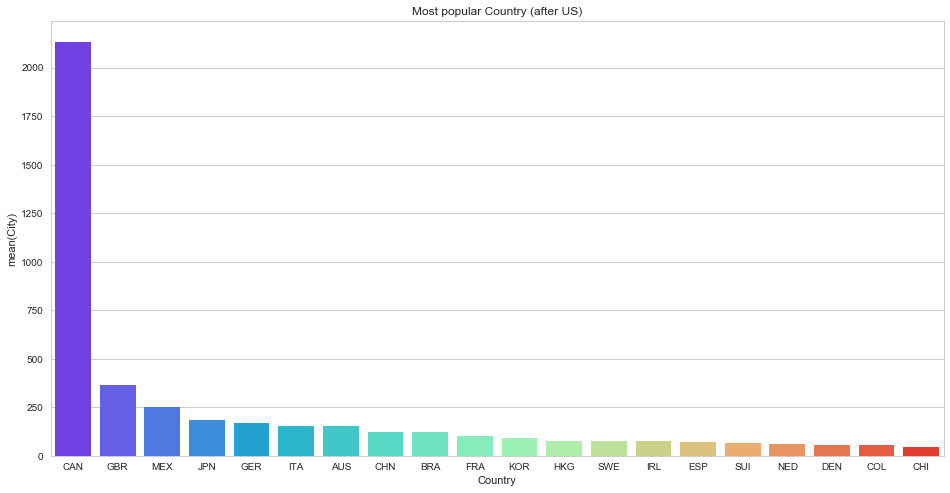

In [15]:
s = pd.DataFrame(df.groupby('Country').count()['City'].sort_values(ascending=False).head(21))[1:]
g = sns.barplot(s.index, s["City"], palette='rainbow')
g.figure.set_size_inches(16,8)
g.set_title("Most popular Country (after US)")

### most popular country without USA and Canada

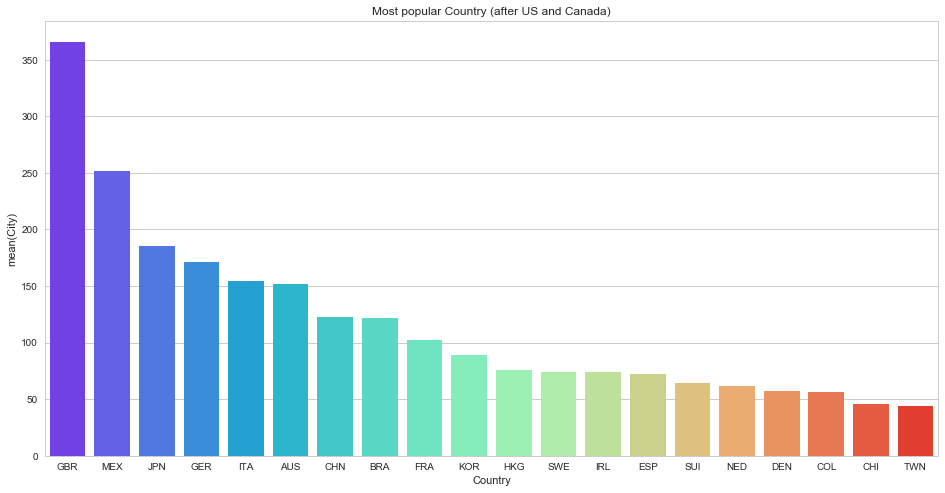

In [16]:
s = pd.DataFrame(df.groupby('Country').count()['City'].sort_values(ascending=False).head(22))[2:]
g = sns.barplot(s.index, s["City"], palette='rainbow')
g.figure.set_size_inches(16,8)
g.set_title("Most popular Country (after US and Canada)")

## Most popular city

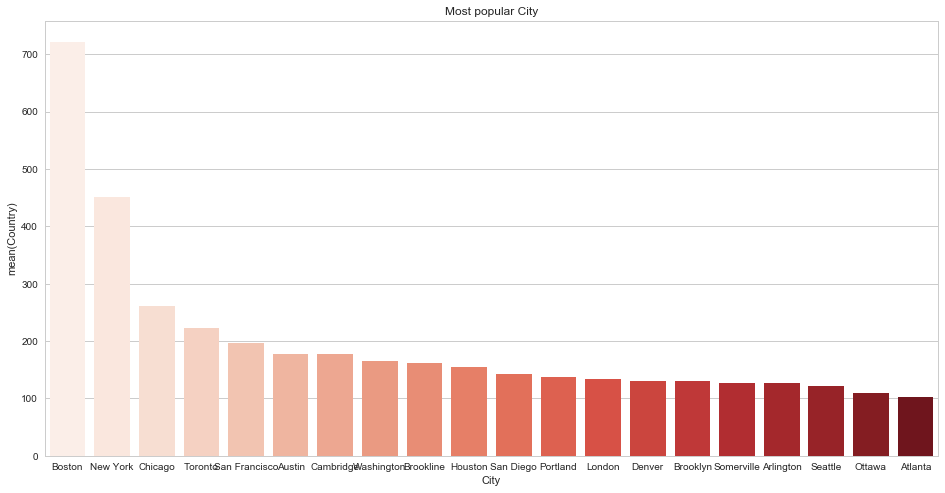

In [17]:
s = pd.DataFrame(df.groupby('City').count()['Country'].sort_values(ascending=False).head(20))
g = sns.barplot(s.index, s["Country"], palette='Reds')
g.figure.set_size_inches(16,8)
g.set_title("Most popular City")

## Most popular state

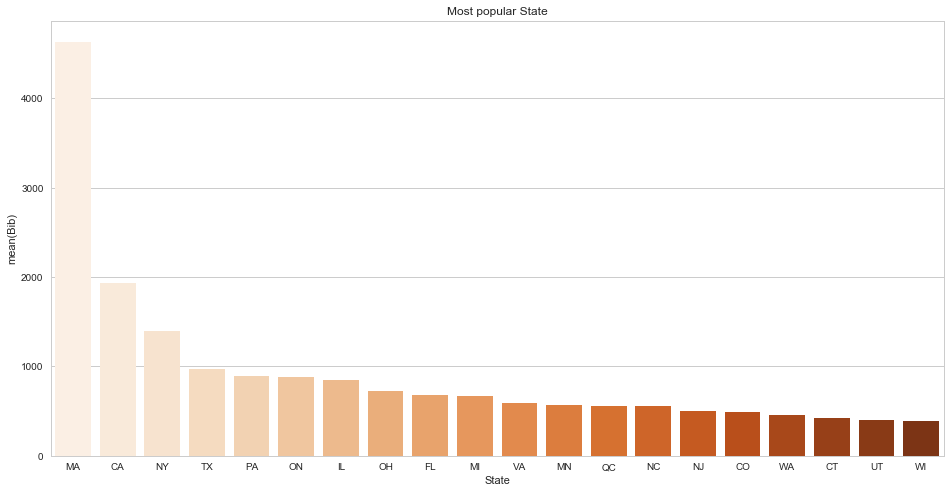

In [18]:
s = df.groupby('State').count()['Bib'].sort_values(ascending=False).head(20)
g = sns.barplot(s.index, s, palette="Oranges")
g.figure.set_size_inches(16,8)
g.set_title("Most popular State")

## Most popular last name

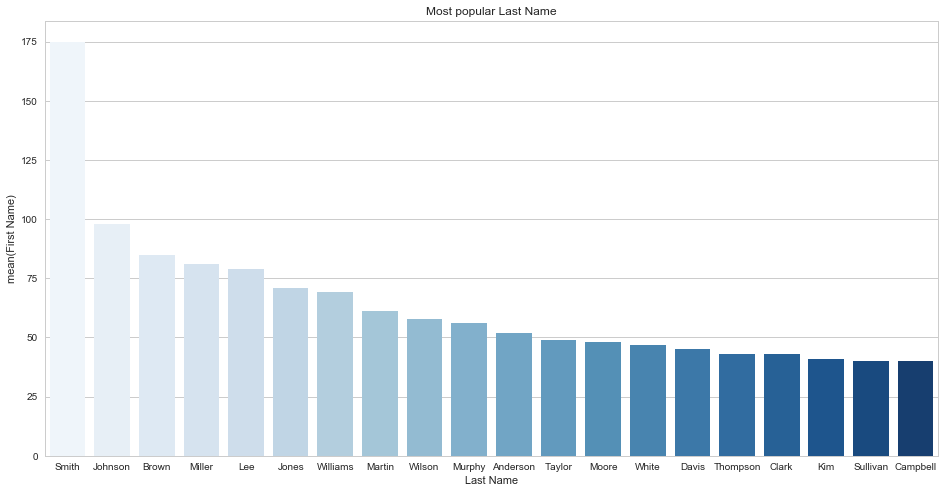

In [19]:
s = pd.DataFrame(df.groupby('Last Name').count()['First Name'].sort_values(ascending=False).head(20))
g = sns.barplot(s.index, s["First Name"], palette='Blues')
g.figure.set_size_inches(16,8)
g.set_title("Most popular Last Name")

## Most popular first name

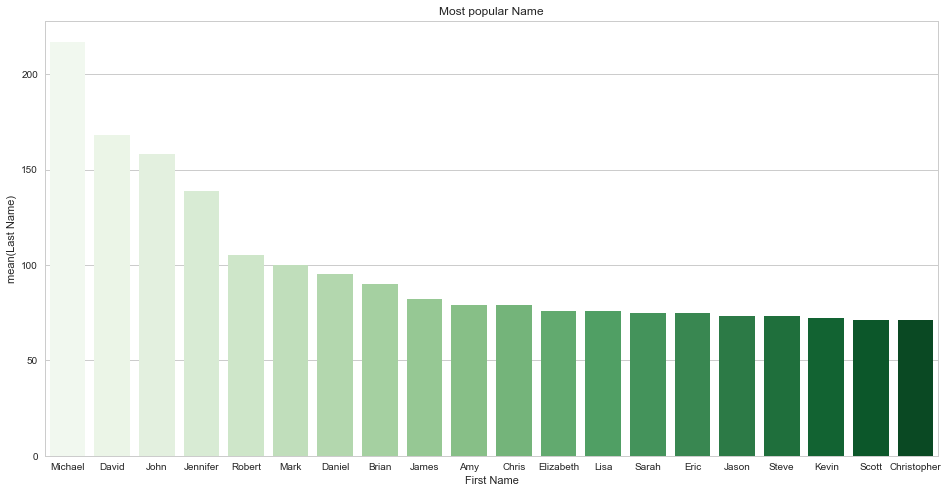

In [20]:
s = pd.DataFrame(df.groupby('First Name').count()['Last Name'].sort_values(ascending=False).head(20))
g = sns.barplot(s.index, s["Last Name"], palette='Greens')
g.figure.set_size_inches(16,8)
g.set_title("Most popular Name")

### In progress... analysis of fist half vs second half...

In [21]:
df['Half_2'] = df['Official Time'] - df['Half']

In [22]:
df['Half_2'] = pd.to_datetime(df['Half_2'])

#### Not sure why I need to take this off from the Half_2 to make it right?

In [23]:
df["Half_2"] = df["Half_2"]-pd.to_timedelta(70, 'Y')-pd.to_timedelta(36, 'm')

#### Calculate the difference between the first and second half 

In [24]:
df['2nd_Split'] = (df['Half_2']-df["Half"])

In [25]:
df['2nd_Split']= df['2nd_Split'].apply(lambda x: x.total_seconds()/60)

#### Plot the differences.

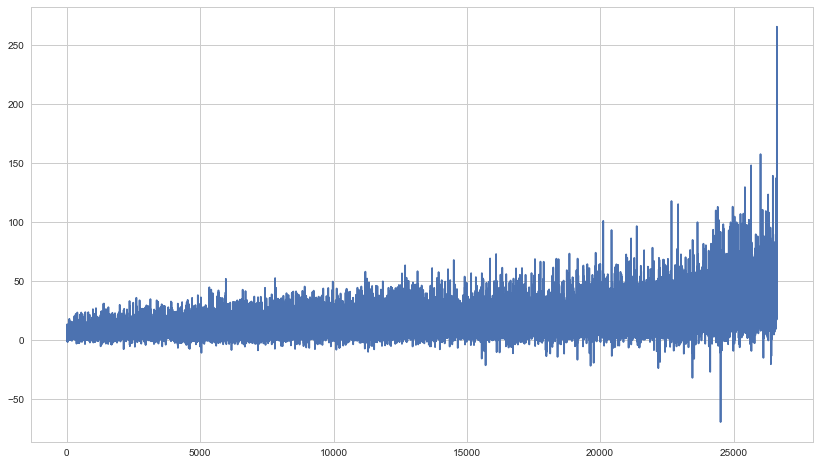

In [26]:
plt.figure(figsize=(14,8))
plt.plot(df['2nd_Split'])

#### Find the extreme cases of possitive split and negative split

In [27]:
df[df['2nd_Split'] == df['2nd_Split'].max()][['5K', '10K','15K', '20K', '25K', '30K', '35K', '40K']]

,5K,10K,15K,20K,25K,30K,35K,40K
26624,1900-01-01 00:20:58,1900-01-01 00:41:41,1900-01-01 01:02:29,1900-01-01 01:23:34,1900-01-01 01:45:00,1900-01-01 02:07:21,1900-01-01 02:31:21,1900-01-01 06:54:20


In [28]:
df[df['2nd_Split'] == df['2nd_Split'].max()]

,Bib,Age,M/F,City,State,Country,Citizen,Unnamed: 8,5K,10K,...,Pace,Proj Time,Official Time,Overall,Gender,Division,First Name,Last Name,Half_2,2nd_Split
26624,4358,43,M,Yardley,PA,USA,NaN,NaN,1900-01-01 00:20:58,1900-01-01 00:41:41,...,1900-01-01 00:16:53,1900-01-01 07:22:23,1900-01-01 07:22:23,26624,14461,1994,Steven J,Hall,1900-01-01 05:54:05,265.783333


In [29]:
df[df['2nd_Split'] == df['2nd_Split'].min()][['5K', '10K', '15K', '20K', '25K', '30K', '35K', '40K', 'Division']]

,5K,10K,15K,20K,25K,30K,35K,40K,Division
24513,1900-01-01 00:22:00,1900-01-01 00:45:02,1900-01-01 01:22:46,1900-01-01 02:59:37,1900-01-01 03:27:32,1900-01-01 03:55:42,1900-01-01 04:21:36,1900-01-01 04:49:14,4503


In [30]:
df[df['2nd_Split'] == df['2nd_Split'].min()]

,Bib,Age,M/F,City,State,Country,Citizen,Unnamed: 8,5K,10K,...,Pace,Proj Time,Official Time,Overall,Gender,Division,First Name,Last Name,Half_2,2nd_Split
24513,6698,39,M,Byron Center,MI,USA,NaN,NaN,1900-01-01 00:22:00,1900-01-01 00:45:02,...,1900-01-01 00:11:29,1900-01-01 05:00:51,1900-01-01 05:00:51,24513,13588,4503,Brian R.,Cunningham,1900-01-01 01:55:39,-69.55


### Find how many negative splits

In [45]:
df[df['2nd_Split'] < 0].sort_values(by='2nd_Split')

,Bib,Age,M/F,City,State,Country,Citizen,Unnamed: 8,5K,10K,...,Pace,Proj Time,Official Time,Overall,Gender,Division,First Name,Last Name,Half_2,2nd_Split
24513,6698,39,M,Byron Center,MI,USA,NaN,NaN,1900-01-01 00:22:00,1900-01-01 00:45:02,...,1900-01-01 00:11:29,1900-01-01 05:00:51,1900-01-01 05:00:51,24513,13588,4503,Brian R.,Cunningham,1900-01-01 01:55:39,-69.550000
23458,17816,30,F,Denver,CO,USA,NaN,NaN,1900-01-01 00:27:34,1900-01-01 00:54:31,...,1900-01-01 00:10:57,1900-01-01 04:46:53,1900-01-01 04:46:53,23458,10365,5042,Meaghan E,Mahoney,1900-01-01 02:07:25,-32.050000
24124,1566,38,M,Bellevue,WA,USA,NaN,NaN,1900-01-01 00:31:04,1900-01-01 01:06:21,...,1900-01-01 00:11:16,1900-01-01 04:55:13,1900-01-01 04:55:13,24124,13401,4450,Mathew J.,Hong,1900-01-01 02:14:07,-26.983333
22178,19021,40,F,Ogden,UT,USA,NaN,NaN,1900-01-01 00:30:38,1900-01-01 01:04:06,...,1900-01-01 00:10:25,1900-01-01 04:33:05,1900-01-01 04:33:05,22178,9697,1634,Danielle,Nielsen,1900-01-01 02:04:38,-23.816667
19639,5023,29,M,Bowling Green,KY,USA,NaN,NaN,1900-01-01 00:31:59,1900-01-01 01:06:29,...,1900-01-01 00:09:43,1900-01-01 04:14:43,1900-01-01 04:14:43,19639,11370,3952,David J,Croxton,1900-01-01 01:56:27,-21.816667
15702,25031,59,F,Hopkinton,MA,USA,NaN,NaN,1900-01-01 00:25:18,1900-01-01 00:51:28,...,1900-01-01 00:09:01,1900-01-01 03:56:00,1900-01-01 03:56:00,15702,5943,88,Catherine L,Howe,1900-01-01 01:47:18,-21.400000
26399,276,39,M,Kailua,HI,USA,NaN,NaN,1900-01-01 00:43:56,1900-01-01 01:27:49,...,1900-01-01 00:13:30,1900-01-01 05:53:42,1900-01-01 05:53:42,26399,14371,4772,Michael,Arnstein,1900-01-01 02:46:36,-20.500000
19755,26442,23,M,East Boston,MA,USA,NaN,NaN,1900-01-01 00:35:14,1900-01-01 01:06:38,...,1900-01-01 00:09:45,1900-01-01 04:15:26,1900-01-01 04:15:26,19755,11423,3971,Robert,Durben,1900-01-01 01:58:04,-19.300000
22244,16691,58,M,Mesa,AZ,USA,NaN,NaN,1900-01-01 00:28:41,1900-01-01 01:02:24,...,1900-01-01 00:10:27,1900-01-01 04:33:47,1900-01-01 04:33:47,22244,12514,1332,Jeffrey A,Donnelly,1900-01-01 02:07:36,-18.583333
19146,9113,45,M,Dubuque,IA,USA,NaN,NaN,1900-01-01 00:31:52,1900-01-01 01:08:33,...,1900-01-01 00:09:37,1900-01-01 04:11:55,1900-01-01 04:11:55,19146,11161,2087,Curt,Ehlinger,1900-01-01 01:57:36,-16.716667


#### Find the ones that have identical first half and second half

In [47]:
df[df['2nd_Split']== 0].sort_values(by='2nd_Split')

,Bib,Age,M/F,City,State,Country,Citizen,Unnamed: 8,5K,10K,...,Pace,Proj Time,Official Time,Overall,Gender,Division,First Name,Last Name,Half_2,2nd_Split
1,1,26,M,Ambo,NaN,ETH,NaN,NaN,1900-01-01 00:15:47,1900-01-01 00:31:21,...,1900-01-01 00:05:06,1900-01-01 02:13:32,1900-01-01 02:13:32,2,2,2,Lelisa,Desisa,1900-01-01 01:06:46,0.0
1397,7257,46,M,Lakewood,CO,USA,NaN,NaN,1900-01-01 00:21:18,1900-01-01 00:42:41,...,1900-01-01 00:06:52,1900-01-01 02:59:38,1900-01-01 02:59:38,1398,1317,109,Monte,Merz,1900-01-01 01:29:49,0.0
4621,16374,43,F,Seattle,WA,USA,NaN,NaN,1900-01-01 00:23:08,1900-01-01 00:46:01,...,1900-01-01 00:07:35,1900-01-01 03:18:36,1900-01-01 03:18:36,4622,620,72,Anne,Theisen,1900-01-01 01:39:18,0.0
7045,16576,53,F,Sellersburg,IN,USA,NaN,NaN,1900-01-01 00:24:15,1900-01-01 00:49:04,...,1900-01-01 00:07:56,1900-01-01 03:27:50,1900-01-01 03:27:50,7045,1406,37,Rachel A,Parrella,1900-01-01 01:43:55,0.0
7398,19409,39,F,Santa Barbara,CA,USA,NaN,NaN,1900-01-01 00:24:51,1900-01-01 00:49:23,...,1900-01-01 00:07:59,1900-01-01 03:28:54,1900-01-01 03:28:54,7398,1548,1236,Jennifer,Miller,1900-01-01 01:44:27,0.0
11607,20707,43,F,Joppa,MD,USA,NaN,NaN,1900-01-01 00:25:51,1900-01-01 00:52:08,...,1900-01-01 00:08:30,1900-01-01 03:42:26,1900-01-01 03:42:26,11607,3574,574,Stacey,Esposito,1900-01-01 01:51:13,0.0
